In [1]:
from teleconnections.plots import hovmoller_plot
from teleconnections import mjo_hovmoller
from aqua import Reader

In [2]:
telecname = 'MJO2'

model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_1h_0.25deg'

In [3]:
reader = Reader(model=model,exp=exp,source=source, regrid='r025', freq='daily')
data = reader.retrieve()

In [4]:
sel = {'time': slice('2021-01-01','2021-06-30')}

data_sel = data.sel(**sel)

In [5]:
data_sel = reader.timmean(data_sel)
data_sel = reader.regrid(data_sel)

In [6]:
data_smooth = mjo_hovmoller(data_sel, telecname=telecname)

2023-07-15 10:32:10 :: Hovmoller :: DEBUG    -> Plotting Hovmoller diagram
2023-07-15 10:32:10 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2023-07-15 10:32:10 :: Hovmoller :: DEBUG    -> Cbar limits set by user
2023-07-15 10:32:10 :: Hovmoller :: DEBUG    -> vmin: -80, vmax: 80
2023-07-15 10:32:10 :: Hovmoller :: DEBUG    -> Centering colorbar around zero
2023-07-15 10:32:10 :: Hovmoller :: WARNING  -> Cbar limits set by user, ignoring center
2023-07-15 10:32:10 :: Hovmoller :: DEBUG    -> vmin: -80, vmax: 80


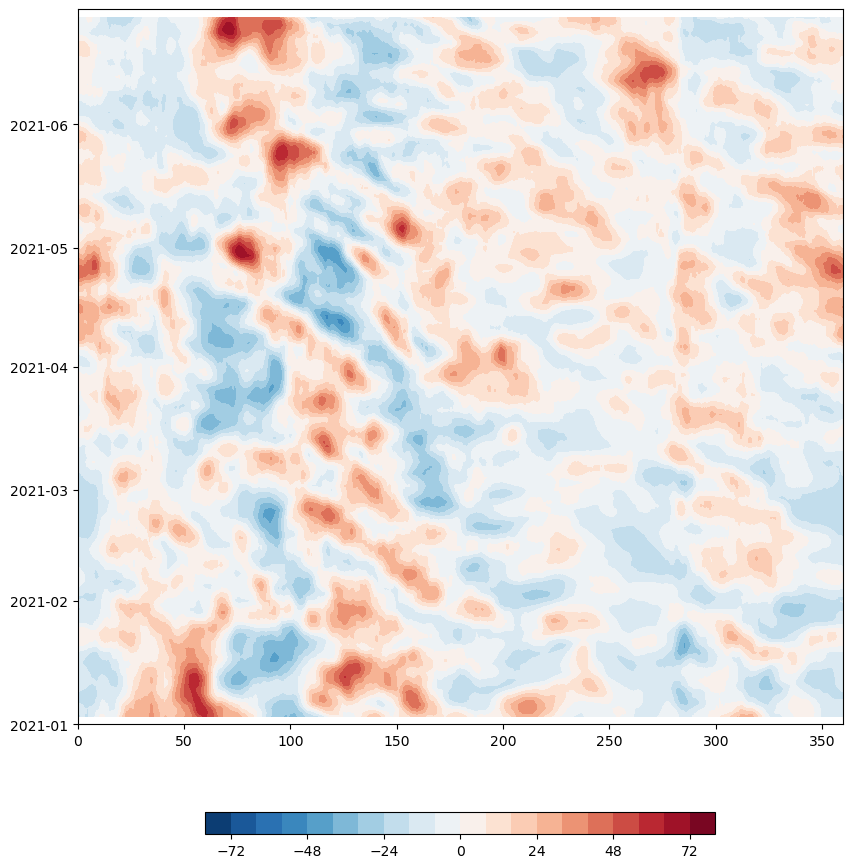

In [7]:
hovmoller_plot(data_smooth, dim='lat', invert_axis=True, nlevels=21, loglevel='DEBUG', center=True,vmin=-80,vmax=80)

In [10]:
data_smooth_wind = mjo_hovmoller(data=data_sel, var='10u', telecname=telecname)

2023-07-15 10:36:53 :: Hovmoller :: DEBUG    -> Plotting Hovmoller diagram
2023-07-15 10:36:53 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2023-07-15 10:36:53 :: Hovmoller :: DEBUG    -> Centering colorbar around zero
2023-07-15 10:36:53 :: Hovmoller :: WARNING  -> Exploring data to find absmax, may take a while
2023-07-15 10:37:33 :: Hovmoller :: DEBUG    -> vmin: -6.001974452983882, vmax: 6.001974452983882


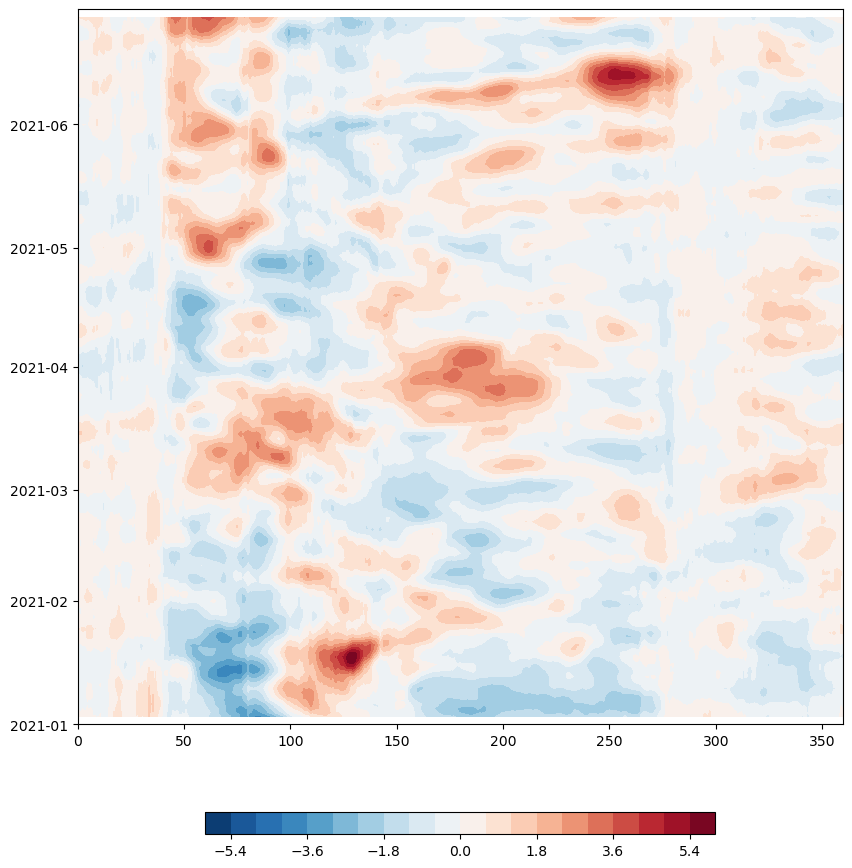

In [13]:
hovmoller_plot(data_smooth_wind, dim='lat', invert_axis=True, nlevels=21, loglevel='DEBUG', center=True)